In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
import scipy
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import pysindy as ps
import pandas as pd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#SINDy setup
poly_order = 1
threshold = 0.001 
smoothed_fd=ps.SmoothedFiniteDifference()

modelLCA = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    differentiation_method=smoothed_fd
)

In [11]:
#Params
S1=1.85 #Stimulus input amplitude to y1
S2=1.85#Stimulus input amplitude to y2
b=5 #Mutual inhibitory coupling strength between the y's 
k=5 # Rate of decay of the y's
z=.9#0.89881186# Decision threshold
c=0.165#.165# Size of the noise
dt=.01#timestep

#initial_conditions
y1=0
y2=0
Model_total=10
T_Total=1000 #Total time

In [12]:
coef_mat=[]
decision_t_avg=[]#t[0:(len(x_data_1[:,1]))]
error_trials=[]
choice_trials=[]
for model in range(Model_total):
    t = np.arange(0, T_Total, dt)
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    error=False   
        
    for p in range(len(x)-1):        
        x[p+1] = x[p]+dt*(-k*x[p]-b*y[p]+S1) + c*np.sqrt(dt)*np.random.randn()
        y[p+1] =y[p]+dt*(-k*y[p]-b*x[p]+S2) + c*np.sqrt(dt)*np.random.randn()

        if x[p]>=z: #or x[p]<0:# Condition for making the correct response  
            x=x[0:p+1]
            y=y[0:p+1]
            choice_trials.append(1)
            break # Stop the time "for" loop 
        elif y[p]>=z: #or y[p]<0:# Condition for making the error response    
            x=x[0:p+1]
            y=y[0:p+1]
            error=True
            choice_trials.append(0)
            break # Stop the time "for" loop

    x_data_1= np.vstack((x, y)).T
    decision_t_avg.append((len(x_data_1[:,1])*0.01))

    #fit model
    modelLCA.fit(x_data_1, t=dt)
    #print(model)
    initial_con_1 = [0,0]
    #print(t)
    x_sim = modelLCA.simulate(initial_con_1, t) #simulate data

    #cut simulated data when it passes decision threshold
    q=[]
    r=[]
    for i in range(np.size(x_sim,0)):
        q.append(x_sim[i,0])
        r.append(x_sim[i,1])
        if x_sim[i,0]>=z :
            if error==True:
                error_trials.append(0)
                break
            elif error==False :
                error_trials.append(1)
                break
            #break    
        elif x_sim[i,1]>=z :
            if error==False:
                error_trials.append(0)
                break
            elif error==True :
                error_trials.append(1)
                break
            #break

    #print(q,",",r)        
    x_sim_1= np.vstack((q, r)).T
    #modelLCA.print()
    coef_mat.append(modelLCA.coefficients())

time_panda=pd.DataFrame(decision_t_avg, columns=['$t$'])
coef_mat=np.array(coef_mat)
coef_mat=coef_mat.reshape(Model_total,1*6)
coef_panda=pd.DataFrame(coef_mat, columns=['$s1$','$k^1$','$b^1$','$s2$','$b^2$','$k^2$'])

In [13]:
#choice error (model)
print("choice trials:" + str(len(choice_trials)))
print(choice_trials)
print("number of choice error choices:"+str(choice_trials.count(0)))
if choice_trials.count(0)!= 0 :
    print("choice error perecentage:"+str((choice_trials.count(0))/(len(choice_trials))*100)+"%")
elif choice_trials.count(0)== 0:
    print("choice error percentage is zero")

choice trials:10
[0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
number of choice error choices:4
choice error perecentage:40.0%


In [16]:
#predction error (sindy)
print("number of trials:" + str(len(error_trials)))
print(error_trials)
print("number of prediction error trials:"+str(error_trials.count(0)))
if error_trials.count(0)!= 0 :
    print("prediction error perecentage:"+str((error_trials.count(0))/(len(error_trials))*100)+"%")
elif error_trials.count(0)== 0:
    print("prediction error percentage is zero")

number of trials:9
[1, 1, 1, 1, 1, 1, 1, 1, 1]
number of prediction error trials:0
prediction error percentage is zero


# There is no prediction or choice trial data so will need to run again for this.

In [239]:
#trial_1000_0.to_pickle("1000trialLCA")
#trial_1000_0=pd.read_pickle("1000trialLCA")

trial_1000_0=coef_panda
trial_1000_error_0=error_trials
print("number of trials:" + str(len(trial_1000_error_0)))
t1000_0_error_prediction=(trial_1000_error_0.count(0))/(len(trial_1000_error_0))*100
if trial_1000_error_0.count(0)!= 0 :
    print("error perecentage:"+str(t1000_0_error_prediction)+"%")
elif trial_1000_error_0.count(0)== 0:
    print("error percentage is zero")
trial_1000_0.mean()

number of trials:969
error perecentage:10.8359133126935%


$s1$     0.217455
$k^1$   -0.474541
$b^1$   -0.577518
$s2$     0.205309
$b^2$   -0.554887
$k^2$   -0.450620
dtype: float64

In [15]:
#trial_500_0.to_pickle("500trialLCA")
#trial_500_0=pd.read_pickle("500trialLCA")

# trial_500_0=coef_panda
# trial_500_error_0=error_trials
# trial_500_choice_0=choice_trials


print("number of trials:" + str(len(trial_500_error_0)))
t500_0_error_prediction=(trial_500_error_0.count(0))/(len(trial_500_error_0))*100
if trial_500_error_0.count(0)!= 0 :
    print("error perecentage:"+str(t500_0_error_prediction)+"%")
elif trial_500_error_0.count(0)== 0:
    print("error percentage is zero")

print("//////")    

print("trials:" + str(len(trial_500_choice_0)))
#print(trial_500_choice_0)
#print("number of choice error choices:"+str(trial_500_choice_0.count(0)))
if trial_500_choice_0.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_500_choice_0.count(0))/(len(trial_500_choice_0))*100)+"%")
elif trial_500_choice_0.count(0)== 0:
    print("choice error percentage is zero")

number of trials:473
error perecentage:11.627906976744185%
//////
trials:500
choice error perecentage:51.0%


In [18]:
#time_panda.max()

# trial_50=coef_panda
# trial_50_error=error_trials
# print("number of trials:" + str(len(trial_50_error)))
# print("error perecentage:"+str((len(trial_50_error))/(trial_50_error.count(0))))
#trial_50

# trial_100_0.to_pickle("trial_100_0")
# trial_100_1.to_pickle("trial_100_1")
# trial_100_2.to_pickle("trial_100_2")
# trial_100_3.to_pickle("trial_100_3")
# trial_100_4.to_pickle("trial_100_4")

# trial_100_0=coef_panda
# trial_100_error_0=error_trials
# trial_100_choice_0=choice_trials

# trial_100_1=coef_panda
# trial_100_error_1=error_trials
# trial_100_choice_1=choice_trials

# trial_100_2=coef_panda
# trial_100_error_2=error_trials
# trial_100_choice_2=choice_trials

# trial_100_3=coef_panda
# trial_100_error_3=error_trials
# trial_100_choice_3=choice_trials

# trial_100_4=coef_panda
# trial_100_error_4=error_trials
# trial_100_choice_4=choice_trials

print("number of trials:" + str(len(trial_100_error_0)))
t100_0_error_prediction=(trial_100_error_0.count(0))/(len(trial_100_error_0))*100
if trial_100_error_0.count(0)!= 0 :
    print("error perecentage:"+str(t100_0_error_prediction)+"%")
elif trial_100_error_0.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_100_choice_0)))
#print(trial_100_choice_0)
#print("number of choice error choices:"+str(trial_100_choice_0.count(0)))
if trial_100_choice_0.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_100_choice_0.count(0))/(len(trial_100_choice_0))*100)+"%")
elif trial_100_choice_0.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_100_error_1)))
t100_1_error_prediction=(trial_100_error_1.count(0))/(len(trial_100_error_1))*100
if trial_100_error_1.count(0)!= 0 :
    print("error perecentage:"+str(t100_1_error_prediction)+"%")
elif trial_100_error_1.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_100_choice_1)))
#print(trial_100_choice_1)
#print("number of choice error choices:"+str(trial_100_choice_1.count(0)))
if trial_100_choice_1.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_100_choice_1.count(0))/(len(trial_100_choice_1))*100)+"%")
elif trial_100_choice_1.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_100_error_2)))
t100_2_error_prediction=(trial_100_error_2.count(0))/(len(trial_100_error_2))*100
if trial_100_error_2.count(0)!= 0 :
    print("error perecentage:"+str(t100_2_error_prediction)+"%")
elif trial_100_error_2.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_100_choice_2)))
#print(trial_100_choice_2)
#print("number of choice error choices:"+str(trial_100_choice_2.count(0)))
if trial_100_choice_2.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_100_choice_2.count(0))/(len(trial_100_choice_2))*100)+"%")
elif trial_100_choice_2.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_100_error_3)))
t100_3_error_prediction=(trial_100_error_3.count(0))/(len(trial_100_error_3))*100
if trial_100_error_3.count(0)!= 0 :
    print("error perecentage:"+str(t100_3_error_prediction)+"%")
elif trial_100_error_3.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_100_choice_3)))
#print(trial_100_choice_3)
#print("number of choice error choices:"+str(trial_100_choice_3.count(0)))
if trial_100_choice_3.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_100_choice_3.count(0))/(len(trial_100_choice_3))*100)+"%")
elif trial_100_choice_3.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_100_error_4)))
t100_4_error_prediction=(trial_100_error_4.count(0))/(len(trial_100_error_4))*100
if trial_100_error_4.count(0)!= 0 :
    print("error perecentage:"+str(t100_4_error_prediction)+"%")
elif trial_100_error_4.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_100_choice_4)))
#print(trial_100_choice_4)
#print("number of choice error choices:"+str(trial_100_choice_4.count(0)))
if trial_100_choice_4.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_100_choice_4.count(0))/(len(trial_100_choice_4))*100)+"%")
elif trial_100_choice_4.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

t100_total_error_prediction=t100_0_error_prediction+t100_1_error_prediction+t100_2_error_prediction+t100_3_error_prediction+t100_4_error_prediction
t100_avg_error_prediction=t100_total_error_prediction/5
print("/////////////")
print("average error percentage:"+str(t100_avg_error_prediction)+"%")

number of trials:43
error perecentage:4.651162790697675%
/////////////
trials:48
choice error perecentage:33.33333333333333%
**********


NameError: name 'trial_100_error_1' is not defined

In [247]:
# trial_200_0.to_pickle("trial_200_0")
# trial_200_1.to_pickle("trial_200_1")
# trial_200_2.to_pickle("trial_200_2")
# trial_200_3.to_pickle("trial_200_3")
# trial_200_4.to_pickle("trial_200_4")

# trial_200_0=coef_panda
# trial_200_error_0=error_trials
# trial_200_choice_0=choice_trials

# trial_200_1=coef_panda
# trial_200_error_1=error_trials
# trial_200_choice_1=choice_trials

# trial_200_2=coef_panda
# trial_200_error_2=error_trials
# trial_200_choice_2=choice_trials

# trial_200_3=coef_panda
# trial_200_error_3=error_trials
# trial_200_choice_3=choice_trials

# trial_200_4=coef_panda
# trial_200_error_4=error_trials
# trial_200_choice_4=choice_trials


print("number of trials:" + str(len(trial_200_error_0)))
t200_0_error_prediction=(trial_200_error_0.count(0))/(len(trial_200_error_0))*100
if trial_200_error_0.count(0)!= 0 :
    print("error perecentage:"+str(t200_0_error_prediction)+"%")
elif trial_200_error_0.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_200_choice_0)))
#print(trial_200_choice_0)
#print("number of choice error choices:"+str(trial_200_choice_0.count(0)))
if trial_200_choice_0.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_200_choice_0.count(0))/(len(trial_200_choice_0))*100)+"%")
elif trial_200_choice_0.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_200_error_1)))
t200_1_error_prediction=(trial_200_error_1.count(0))/(len(trial_200_error_1))*100
if trial_200_error_1.count(0)!= 0 :
    print("error perecentage:"+str(t200_1_error_prediction)+"%")
elif trial_200_error_1.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_200_choice_1)))
#print(trial_200_choice_1)
#print("number of choice error choices:"+str(trial_200_choice_1.count(0)))
if trial_200_choice_1.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_200_choice_1.count(0))/(len(trial_200_choice_1))*100)+"%")
elif trial_200_choice_1.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_200_error_2)))
t200_2_error_prediction=(trial_200_error_2.count(0))/(len(trial_200_error_2))*100
if trial_200_error_2.count(0)!= 0 :
    print("error perecentage:"+str(t200_2_error_prediction)+"%")
elif trial_200_error_2.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_200_choice_2)))
#print(trial_200_choice_2)
#print("number of choice error choices:"+str(trial_200_choice_2.count(0)))
if trial_200_choice_2.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_200_choice_2.count(0))/(len(trial_200_choice_2))*100)+"%")
elif trial_200_choice_2.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_200_error_3)))
t200_3_error_prediction=(trial_200_error_3.count(0))/(len(trial_200_error_3))*100
if trial_200_error_3.count(0)!= 0 :
    print("error perecentage:"+str(t200_3_error_prediction)+"%")
elif trial_200_error_3.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_200_choice_3)))
#print(trial_200_choice_3)
#print("number of choice error choices:"+str(trial_200_choice_3.count(0)))
if trial_200_choice_3.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_200_choice_3.count(0))/(len(trial_200_choice_3))*100)+"%")
elif trial_200_choice_3.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

print("number of trials:" + str(len(trial_200_error_4)))
t200_4_error_prediction=(trial_200_error_4.count(0))/(len(trial_200_error_4))*100
if trial_200_error_4.count(0)!= 0 :
    print("error perecentage:"+str(t200_4_error_prediction)+"%")
elif trial_200_error_4.count(0)== 0:
    print("error percentage is zero")
print("/////////////")    
print("trials:" + str(len(trial_200_choice_4)))
#print(trial_200_choice_4)
#print("number of choice error choices:"+str(trial_200_choice_4.count(0)))
if trial_200_choice_4.count(0)!= 0 :
    print("choice error perecentage:"+str((trial_200_choice_4.count(0))/(len(trial_200_choice_4))*100)+"%")
elif trial_200_choice_4.count(0)== 0:
    print("choice error percentage is zero")
print("**********")

t200_total_error_prediction=t200_0_error_prediction+t200_1_error_prediction+t200_2_error_prediction+t200_3_error_prediction+t200_4_error_prediction
t200_avg_error_prediction=t200_total_error_prediction/5
print("/////////////")
print("average error percentage:"+str(t200_avg_error_prediction)+"%")

number of trials:190
error perecentage:9.473684210526317%
/////////////
number of trials:193
error perecentage:11.917098445595855%
/////////////
number of trials:193
error perecentage:8.808290155440414%
/////////////
number of trials:194
error perecentage:12.371134020618557%
/////////////
number of trials:195
error perecentage:7.6923076923076925%
/////////////
average error percentage:10.052502904897768%


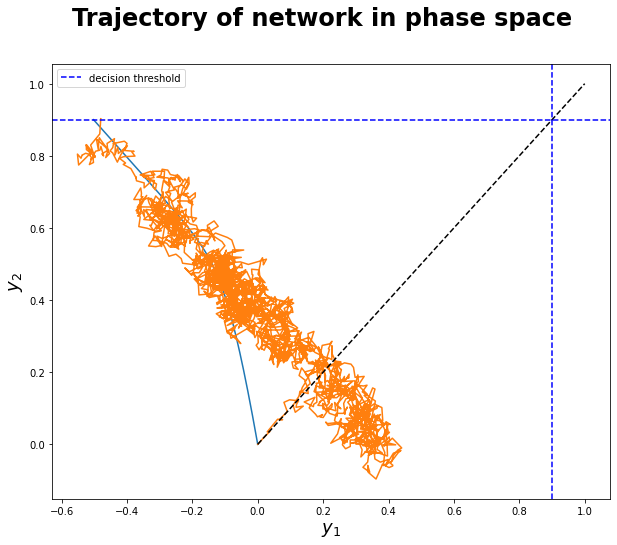

In [24]:
#graphs
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
f.suptitle('Trajectory of network in phase space',fontsize=24, fontweight='bold')
plt.plot(q,r)
plt.plot(x,y)
#plt.plot([-1,-1],[1,1]) 

point1 = [0, 0]
point2 = [1, 1]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'black', linestyle="--")

plt.axvline(x=z,linestyle="dashed", color="blue", label="decision threshold")
plt.axhline(y=z,linestyle="dashed", color="blue")
plt.xlabel("$y_1$",fontsize=18)
plt.ylabel("$y_2$",fontsize=18) 
plt.legend(loc="best")

In [214]:
coef_panda.mean()

$s1$     0.201439
$k^1$   -0.442977
$b^1$   -0.534644
$s2$     0.239392
$b^2$   -0.620993
$k^2$   -0.534485
dtype: float64

In [39]:
#coef_panda.mean()
trial_50.mean()

$s1$     0.223171
$k^1$   -0.492638
$b^1$   -0.608681
$s2$     0.204212
$b^2$   -0.532194
$k^2$   -0.439390
dtype: float64

In [33]:
#coef_panda.std()
trial_50.std()

$s1$     0.183060
$k^1$    0.471130
$b^1$    0.520272
$s2$     0.194621
$b^2$    0.547489
$k^2$    0.527675
dtype: float64

In [41]:
trial_100.mean()

$s1$     0.223171
$k^1$   -0.492638
$b^1$   -0.608681
$s2$     0.204212
$b^2$   -0.532194
$k^2$   -0.439390
dtype: float64

In [40]:
trial_100.std()

$s1$     0.205784
$k^1$    0.498604
$b^1$    0.539934
$s2$     0.205382
$b^2$    0.529055
$k^2$    0.506984
dtype: float64

<AxesSubplot:xlabel='Coefficent Value', ylabel='Density'>

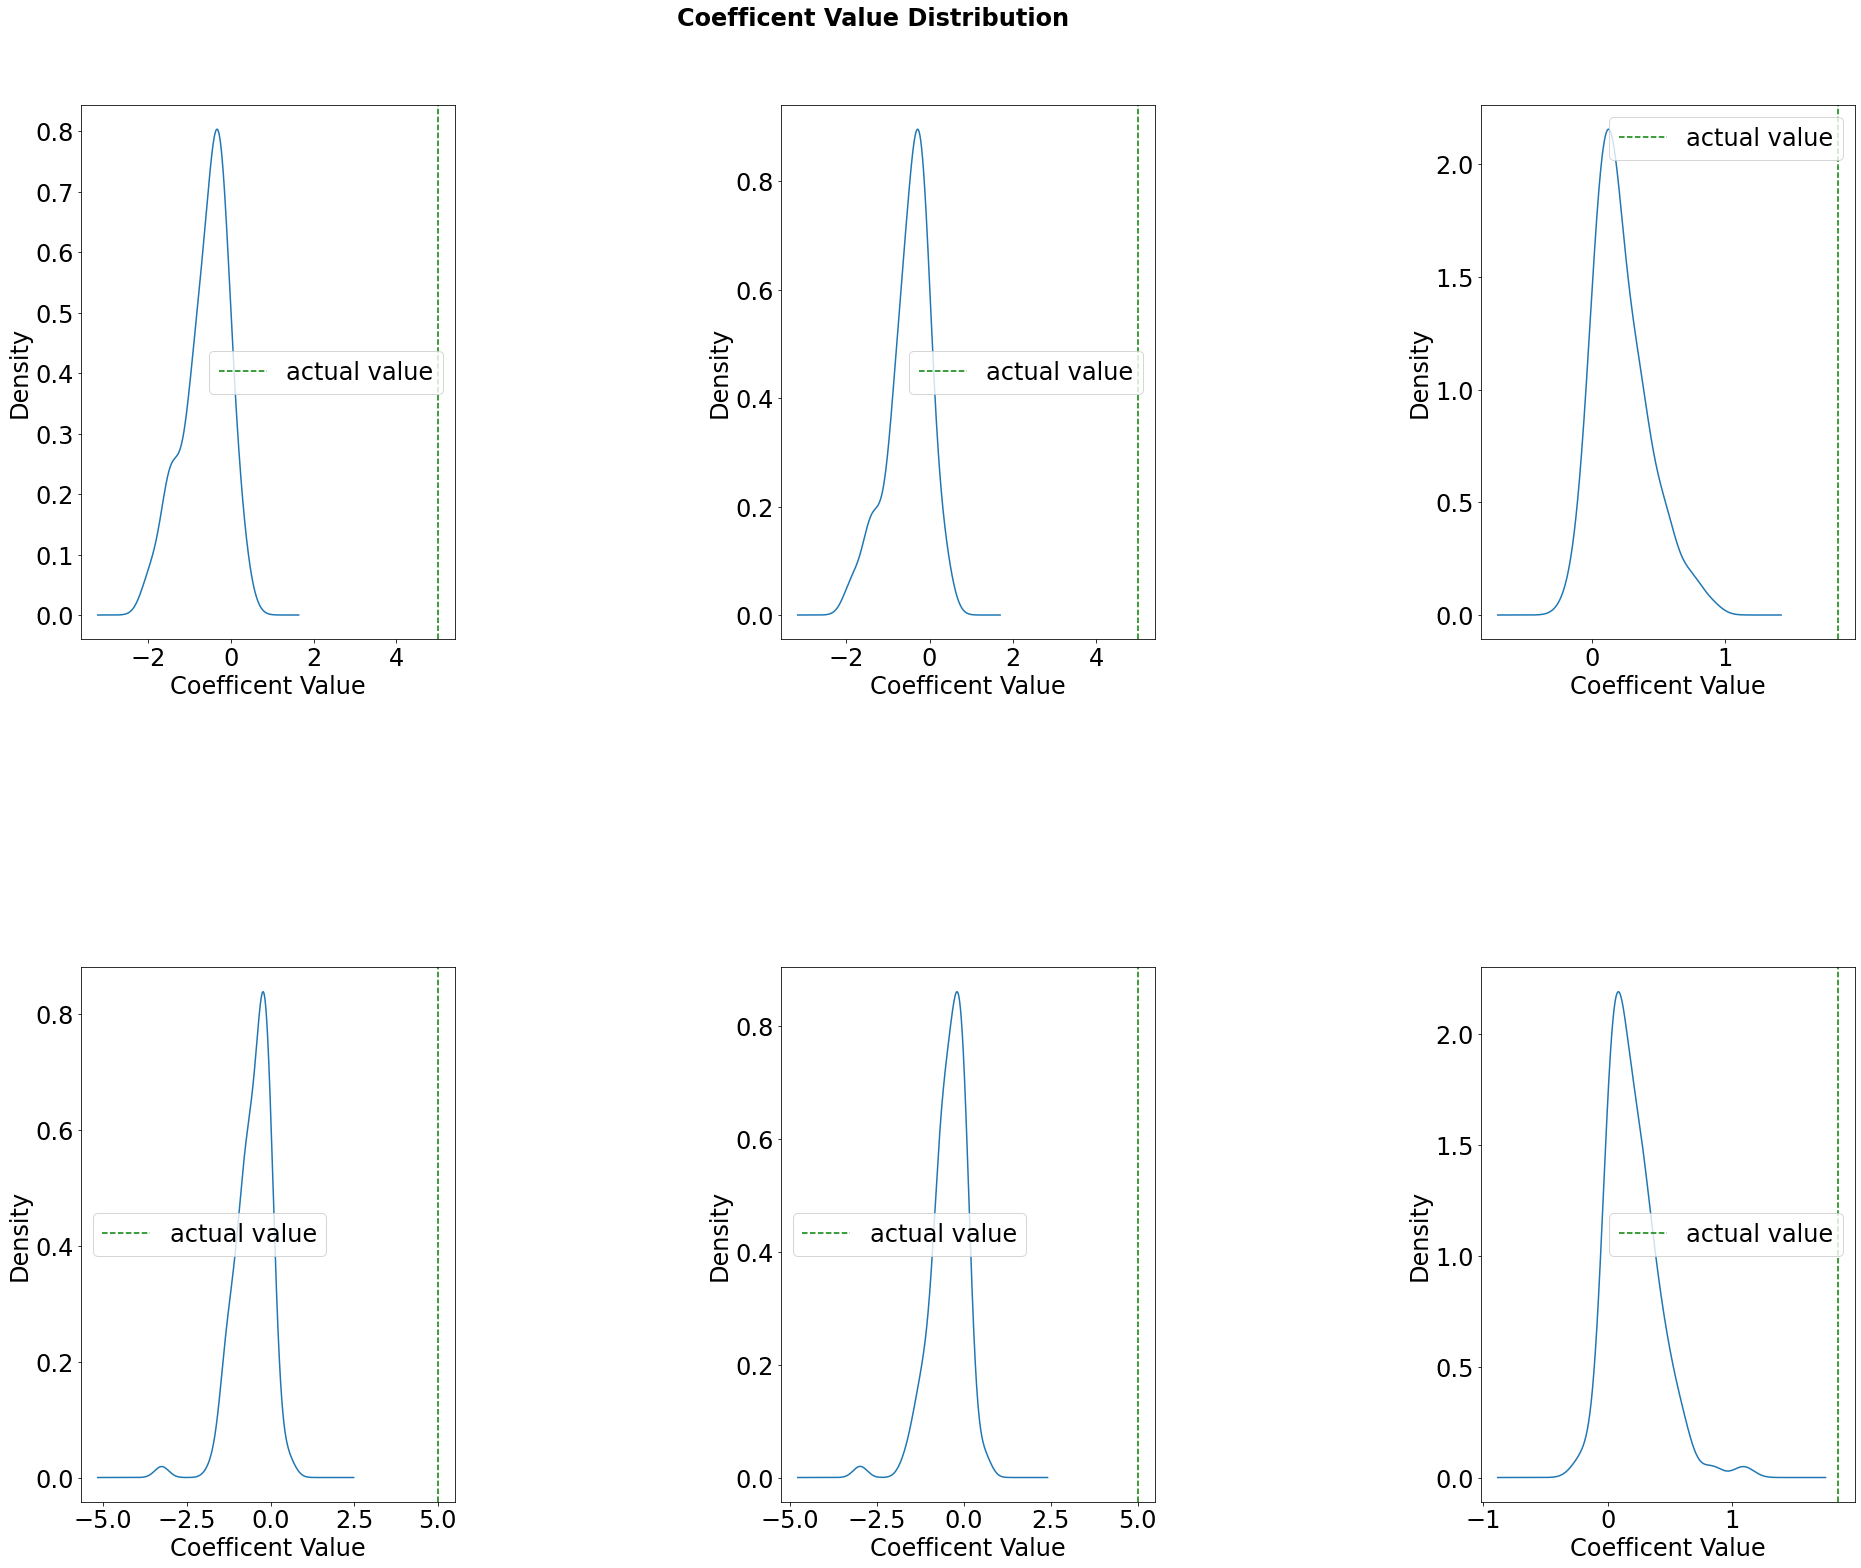

In [58]:
# b_1=coef_panda["$b^1$"]
# k_1=coef_panda["$k^1$"]
# s1=coef_panda["$s1$"]
# b_2=coef_panda["$b^2$"]
# k_2=coef_panda["$k^2$"]
# s2=coef_panda["$s2$"]

# b_1=trial_50["$b^1$"]
# k_1=trial_50["$k^1$"]
# s1=trial_50["$s1$"]
# b_2=trial_50["$b^2$"]
# k_2=trial_50["$k^2$"]
# s2=trial_50["$s2$"]

b_1=trial_100["$b^1$"]
k_1=trial_100["$k^1$"]
s1=trial_100["$s1$"]
b_2=trial_100["$b^2$"]
k_2=trial_100["$k^2$"]
s2=trial_100["$s2$"]

figure, axes = plt.subplots(2, 3)
figure.tight_layout(pad=0.5)
figure.set_figwidth(30)
figure.set_figheight(25)
figure.suptitle('Coefficent Value Distribution',fontsize=24, fontweight='bold')
plt.rcParams.update({'font.size': 24})

#eq1_graphs
axes[0,0].axvline(x=b,linestyle="dashed", color="green" ,label='actual value')
axes[0,0].legend(loc="upper center")
axes[0,0].set(xlabel="Coefficent Value")
axes[0,1].axvline(x=k,linestyle="dashed", color="green" ,label='actual value')
axes[0,1].legend(loc="upper center")
axes[0,1].set(xlabel="Coefficent Value")
axes[0,2].axvline(x=S1,linestyle="dashed", color="green" ,label='actual value')
axes[0,2].legend(loc="upper center")
axes[0,2].set(xlabel="Coefficent Value")
#eq2_graphs
axes[1,0].axvline(x=b,linestyle="dashed", color="green" ,label='actual value')
axes[1,0].legend(loc="upper center")
axes[1,0].set(xlabel="Coefficent Value")
axes[1,1].axvline(x=k,linestyle="dashed", color="green" ,label='actual value')
axes[1,1].legend(loc="upper center")
axes[1,1].set(xlabel="Coefficent Value")
axes[1,2].axvline(x=S2,linestyle="dashed", color="green" ,label='actual value')
axes[1,2].legend(loc="upper center")
axes[1,2].set(xlabel="Coefficent Value")

b_1.plot.kde(ax=axes[0,0])
k_1.plot.kde(ax=axes[0,1])
s1.plot.kde(ax=axes[0,2])
b_2.plot.kde(ax=axes[1,0])
k_2.plot.kde(ax=axes[1,1])
s2.plot.kde(ax=axes[1,2])